In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn import linear_model
 
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('boxoffice.csv',
                 encoding='latin-1')
df.head()

,title,domestic_revenue,world_revenue,distributor,opening_revenue,opening_theaters,budget,MPAA,genres,release_days
0,Star Wars: Episode VIII - The Last Jedi,"$620,181,382","$1,332,539,889",Walt Disney Studios Motion Pictures,"$220,009,584","4,232","$317,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi",382
1,The Fate of the Furious,"$226,008,385","$1,236,005,118",Universal Pictures,"$98,786,705","4,310","$250,000,000",PG-13,"Action,Adventure,Thriller",262
2,Wonder Woman,"$412,563,408","$821,847,012",Warner Bros.,"$103,251,471","4,165","$149,000,000",PG-13,"Action,Adventure,Fantasy,Sci-Fi,War",217
3,Guardians of the Galaxy Vol. 2,"$389,813,101","$863,756,051",Walt Disney Studios Motion Pictures,"$146,510,104","4,347","$200,000,000",PG-13,"Action,Adventure,Comedy,Sci-Fi",241
4,Beauty and the Beast,"$504,014,165","$1,263,521,126",Walt Disney Studios Motion Pictures,"$174,750,616","4,210","$160,000,000",PG,"Family,Fantasy,Musical,Romance",290


In [4]:
df.shape

(2694, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2694 entries, 0 to 2693
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             2694 non-null   object
 1   domestic_revenue  2694 non-null   object
 2   world_revenue     2694 non-null   object
 3   distributor       2694 non-null   object
 4   opening_revenue   2390 non-null   object
 5   opening_theaters  2383 non-null   object
 6   budget            397 non-null    object
 7   MPAA              1225 non-null   object
 8   genres            2655 non-null   object
 9   release_days      2694 non-null   object
dtypes: object(10)
memory usage: 210.6+ KB


In [6]:
df.describe().T

,count,unique,top,freq
title,2694,2468,A Beautiful Planet,3
domestic_revenue,2694,2495,"$11,272,008",3
world_revenue,2694,2501,"$25,681,505",3
distributor,2694,248,Fathom Events,292
opening_revenue,2390,2176,"$4,696",3
opening_theaters,2383,732,1,503
budget,397,124,"$40,000,000",14
MPAA,1225,8,R,568
genres,2655,567,Documentary,351
release_days,2694,457,347,35


In [7]:
#we will predict only domestic_revenue so we don't need world or openening revenue.
to_remove = ['world_revenue', 'opening_revenue']
df.drop(to_remove, axis=1, inplace=True)

In [8]:
df.isnull().sum() * 100 / df.shape[0]

title                0.000000
domestic_revenue     0.000000
distributor          0.000000
opening_theaters    11.544172
budget              85.263549
MPAA                54.528582
genres               1.447661
release_days         0.000000
dtype: float64

In [9]:
# Handling the null value columns
df.drop('budget', axis=1, inplace=True)
 
for col in ['MPAA', 'genres']:
    df[col] = df[col].fillna(df[col].mode()[0])
    
df.dropna(inplace=True)
 
df.isnull().sum().sum()

0

In [10]:
df['domestic_revenue'].str[1:]

0       620,181,382
1       226,008,385
2       412,563,408
3       389,813,101
4       504,014,165
           ...     
2689    176,040,665
2690    175,750,384
2691    209,726,015
2692    188,045,546
2693    229,024,295
Name: domestic_revenue, Length: 2383, dtype: object

In [11]:
df['domestic_revenue'] = df['domestic_revenue'].str[1:]
 
for col in ['domestic_revenue', 'opening_theaters', 'release_days']:
    df[col] = df[col].str.replace(',', '')
 
    # Selecting rows with no null values in the columns on which we are iterating.
    temp = (~df[col].isnull())
    df[temp][col] = df[temp][col].convert_dtypes(float)
 
    df[col] = pd.to_numeric(df[col], errors='coerce')
 


In [26]:
plt.figure(figsize=(10, 5))
sb.countplot(df['MPAA'])
plt.show()

ValueError: could not convert string to float: 'PG-13'

<Figure size 1000x500 with 0 Axes>

In [27]:
df.groupby('MPAA').mean()['domestic_revenue']

TypeError: agg function failed [how->mean,dtype->object]

#### we can observe that the movies with PG or PG-13 ratings generally have their revenue higher than the other rating class.

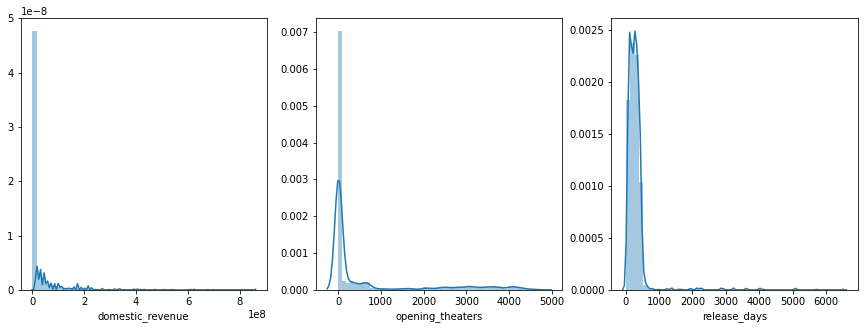

In [ ]:
plt.subplots(figsize=(15, 5))
 
features = ['domestic_revenue', 'opening_theaters', 'release_days']
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.show()

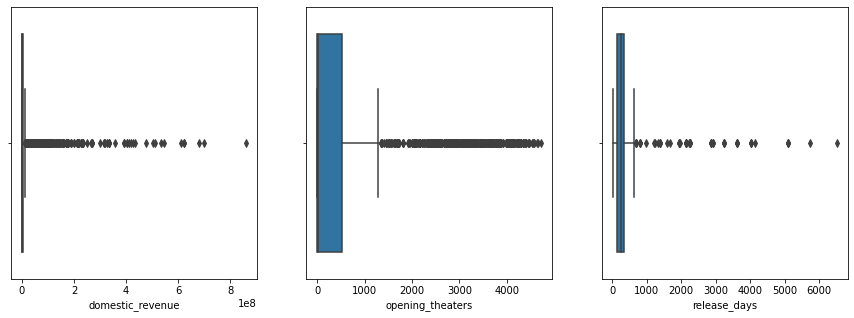

In [ ]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.boxplot(df[col])
plt.show()

In [ ]:
for col in features:
    df[col] = df[col].apply(lambda x: np.log10(x))

NameError: name 'features' is not defined

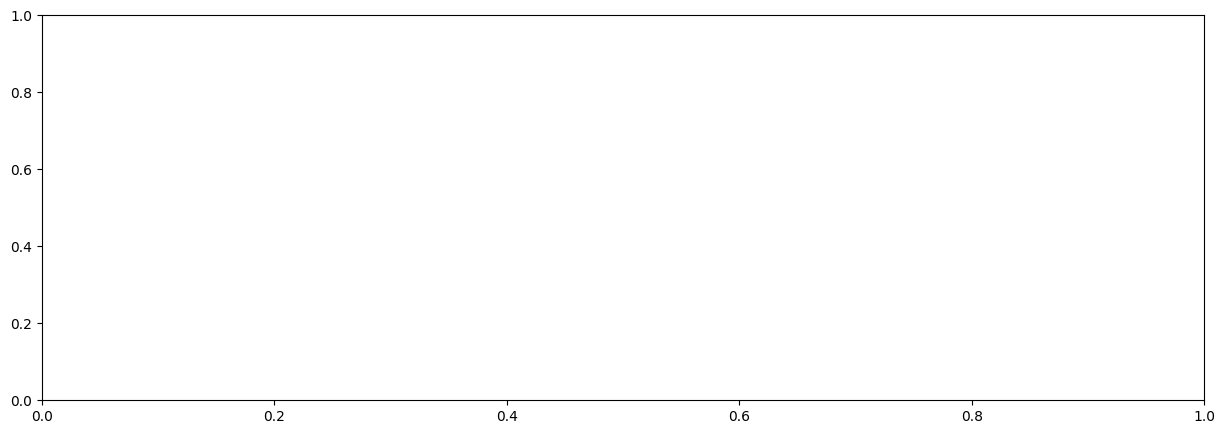

In [14]:
plt.subplots(figsize=(15, 5))
for i, col in enumerate(features):
    plt.subplot(1, 3, i+1)
    sb.distplot(df[col])
plt.tight_layout()
plt.show()

In [15]:
vectorizer = CountVectorizer()
vectorizer.fit(df['genres'])
features = vectorizer.transform(df['genres']).toarray()
 
genres = vectorizer.get_feature_names()
for i, name in enumerate(genres):
    df[name] = features[:, i]

df.drop('genres', axis=1, inplace=True)

AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [16]:
removed = 0
for col in df.loc[:, 'action':'western'].columns:
 
    # Removing columns having more
    # than 95% of the values as zero.
    if (df[col] == 0).mean() > 0.95:
        removed += 1
        df.drop(col, axis=1, inplace=True)

print(removed)
print(df.shape)

KeyError: 'action'

In [ ]:
for col in ['distributor', 'MPAA']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

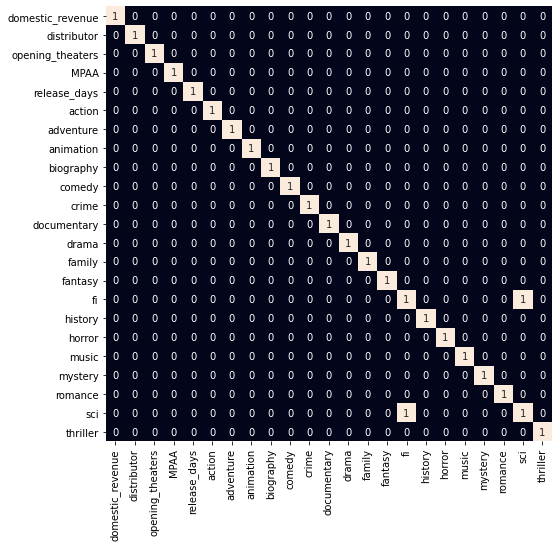

In [ ]:
plt.figure(figsize=(8, 8))
sb.heatmap(df.corr() > 0.8,
           annot=True,
           cbar=False)
plt.show()

### model development

In [17]:
y=df['domestic_revenue']
x=df.drop(['domestic_revenue','title'],axis=1)

In [18]:
x.shape

(2383, 5)

In [19]:
y.shape

(2383,)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=1)
print("x train: ", x_train.shape)
print("x test: ",x_test.shape)
print("y train: ", y_train.shape)
print("y test: ",y_test.shape)

x train:  (1906, 5)
x test:  (477, 5)
y train:  (1906,)
y test:  (477,)


In [21]:
lm=linear_model.LinearRegression()
model=lm.fit(x_train,y_train)

ValueError: could not convert string to float: 'GathrFilms'

In [22]:
model.coef_

NameError: name 'model' is not defined

In [ ]:
model.intercept_

2.7483111627860453

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
print(metrics.mean_squared_error(y_test,y_pred))

0.6485152858976331


In [ ]:
testdata=[[217,3.626546,5,2.582063,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0]]
print(model.predict(testdata))

[7.84360103]


In [24]:
y.to_csv('y.csv')